In [1]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
font = {'size': 16}
plt.rc('font', **font)

In [3]:
# ฟังก์ชันตรวจจับ Drip และคำนวณ % การเปลี่ยนแปลงราคาหลัง Drip
def detect_drip_and_price_change(data, window=12, threshold=-0.05, post_hours=[12, 24, 36, 48, 60, 72]):
    drips = []
    for i in range(len(data) - window - max(post_hours)):
        if drips and (data.index[i] - drips[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Drip ใหม่เริ่มภายใน 12 ชั่วโมงจาก Drip ก่อนหน้า
        
        close_price = data['close'].iloc[i]
        low_price = data['low'].iloc[i:i+window].min()
        drip_pct = (low_price - close_price) / close_price
        if drip_pct <= threshold:
            # หา index ของ Low ภายใน Window
            low_idx = data['low'].iloc[i:i+window].idxmin()
            low_time = low_idx
            low_value = data.loc[low_idx, 'low']
            # คำนวณ % การเปลี่ยนแปลงราคาหลัง Drip
            price_changes = {}
            for h in post_hours:
                try:
                    # หา Close Price หลังจาก Low ไป h ชั่วโมง
                    target_time = low_time + pd.Timedelta(hours=h)
                    closest_idx = data.index.get_indexer([target_time], method='nearest')[0]
                    close_after = data['close'].iloc[closest_idx]
                    price_change_pct = (close_after - low_value) / low_value * 100
                    price_changes[f'change_{h}h'] = price_change_pct
                except:
                    price_changes[f'change_{h}h'] = np.nan  # กรณีไม่มีข้อมูล
            drips.append({
                'start_time': data.index[i],
                'low_time': low_time,
                'close_price': close_price,
                'low_price': low_value,
                'drip_pct': drip_pct * 100,
                **price_changes
            })
            # ข้าม 12 ชั่วโมงเพื่อลด Overlap
            i += window - 1
    return pd.DataFrame(drips)

In [4]:
data = pd.read_pickle(os.path.abspath("../../crypto/datasets/preprocessed/BTCUSDT/1h/features.pkl"))

# ตรวจจับ Drip และคำนวณ % การเปลี่ยนแปลง
post_hours = [2, 4, 6, 12, 18, 24, 36, 48, 60, 72]
drips = detect_drip_and_price_change(data, post_hours=post_hours)

In [5]:
# คำนวณ % จำนวนครั้งที่ราคาเพิ่มขึ้นและลดลง
#post_hours = [12, 24, 36, 48, 60, 72]
rates = []
for h in post_hours:
    col = f'change_{h}h'
    # % ที่ราคาเพิ่มขึ้น (price_change > 0)
    recovery_rate = (drips[col] > 0).mean() * 100
    # % ที่ราคาลดลง (price_change < 0)
    decline_rate = (drips[col] < 0).mean() * 100
    # % ที่ราคาไม่เปลี่ยนแปลง (price_change == 0)
    no_change_rate = (drips[col] == 0).mean() * 100
    rates.append({
        'Hours': h,
        'Recovery Rate (%)': recovery_rate,
        'Decline Rate (%)': decline_rate,
        'No Change Rate (%)': no_change_rate
    })

# สร้าง DataFrame สำหรับผลลัพธ์
rates_df = pd.DataFrame(rates)
print("\nPrice Change Rates After Drip by Hours:")
print(rates_df.round(2))


Price Change Rates After Drip by Hours:
   Hours  Recovery Rate (%)  Decline Rate (%)  No Change Rate (%)
0      2              90.42              9.58                0.00
1      4              85.63             14.37                0.00
2      6              84.23             15.77                0.00
3     12              77.89             22.11                0.00
4     18              73.38             26.62                0.00
5     24              73.80             26.20                0.00
6     36              74.65             25.35                0.00
7     48              71.83             28.03                0.14
8     60              69.86             30.14                0.00
9     72              69.86             30.14                0.00


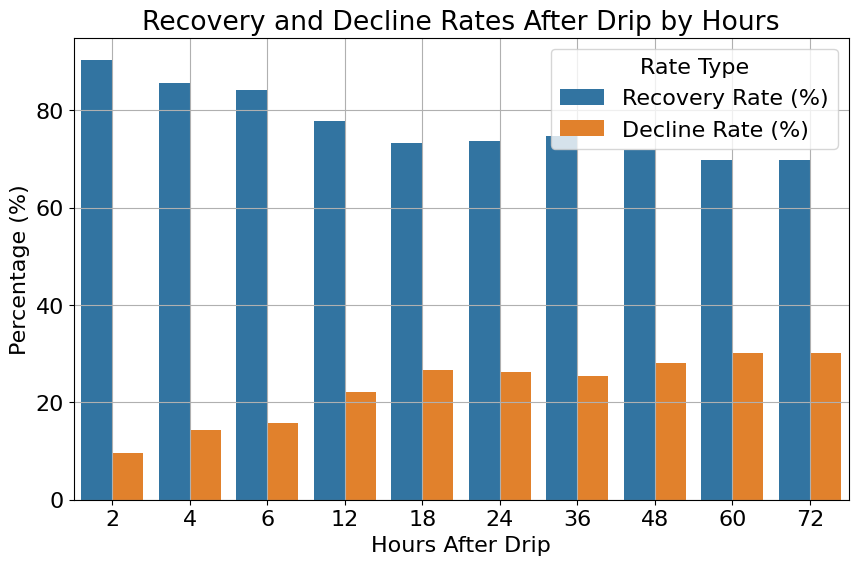

In [6]:
# สร้าง Bar Plot เพื่อแสดง Recovery Rate และ Decline Rate
rates_melted = rates_df.melt(id_vars='Hours', value_vars=['Recovery Rate (%)', 'Decline Rate (%)'], 
                             var_name='Rate Type', value_name='Percentage')
plt.figure(figsize=(10, 6))
sns.barplot(x='Hours', y='Percentage', hue='Rate Type', data=rates_melted)
plt.title('Recovery and Decline Rates After Drip by Hours')
plt.xlabel('Hours After Drip')
plt.ylabel('Percentage (%)')
plt.grid(True)
plt.show()

In [7]:
drips['drip_size_group'] = pd.cut(drips['drip_pct'], bins=[-float('inf'), -10, -5], labels=['Large', 'Small'])
rates_by_size = []
for h in post_hours:
    for size in drips['drip_size_group'].unique():
        subset = drips[drips['drip_size_group'] == size]
        recovery_rate = (subset[f'change_{h}h'] > 0).mean() * 100
        decline_rate = (subset[f'change_{h}h'] < 0).mean() * 100
        rates_by_size.append({
            'Hours': h,
            'Drip Size': size,
            'Recovery Rate (%)': recovery_rate,
            'Decline Rate (%)': decline_rate
        })
print(pd.DataFrame(rates_by_size).round(2))

    Hours Drip Size  Recovery Rate (%)  Decline Rate (%)
0       2     Small              90.00             10.00
1       2     Large              95.00              5.00
2       4     Small              85.08             14.92
3       4     Large              91.67              8.33
4       6     Small              83.54             16.46
5       6     Large              91.67              8.33
6      12     Small              77.08             22.92
7      12     Large              86.67             13.33
8      18     Small              73.08             26.92
9      18     Large              76.67             23.33
10     24     Small              72.77             27.23
11     24     Large              85.00             15.00
12     36     Small              73.23             26.77
13     36     Large              90.00             10.00
14     48     Small              70.92             28.92
15     48     Large              81.67             18.33
16     60     Small            

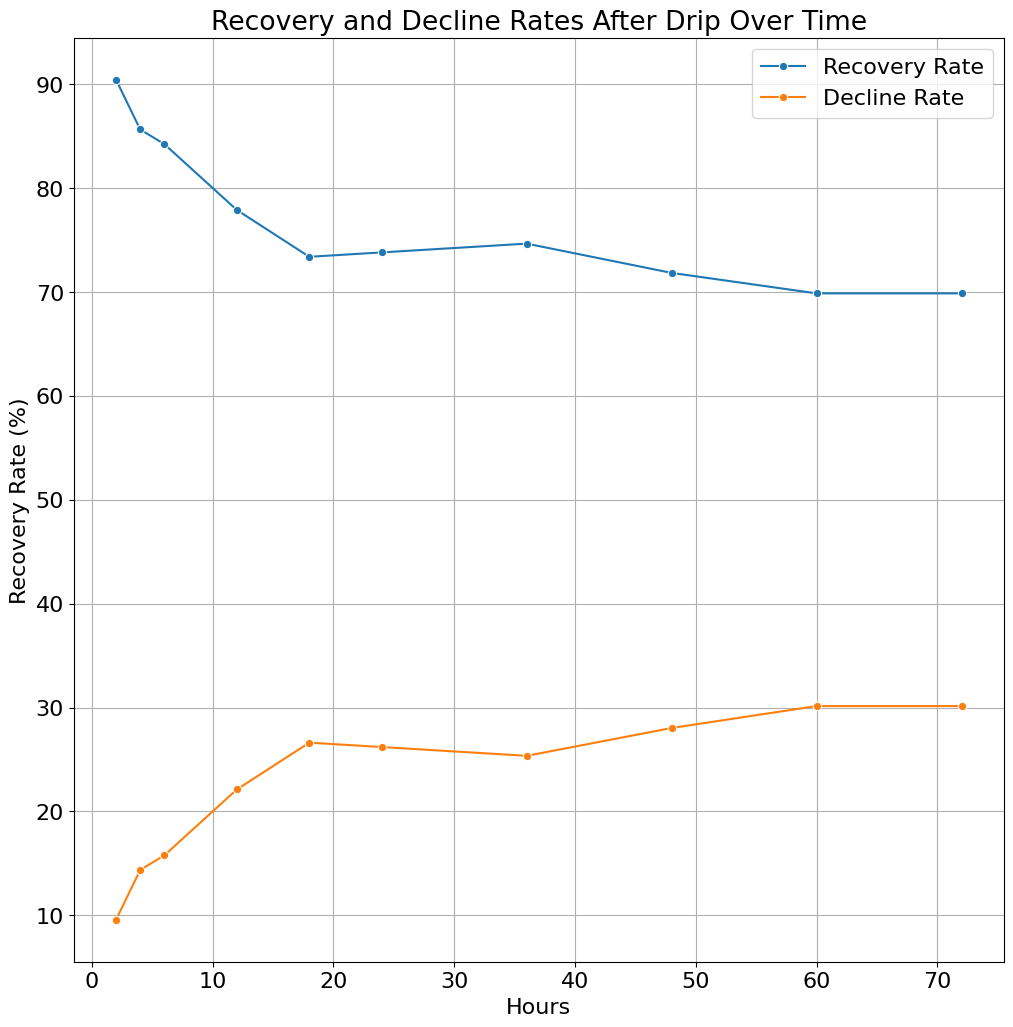

In [8]:
plt.figure(figsize=(12, 12))
sns.lineplot(x='Hours', y='Recovery Rate (%)', data=rates_df, marker='o', label='Recovery Rate')
sns.lineplot(x='Hours', y='Decline Rate (%)', data=rates_df, marker='o', label='Decline Rate')
plt.title('Recovery and Decline Rates After Drip Over Time')
plt.grid(True)
plt.show()